In [36]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
df_data = pd.read_csv('data_processed.csv').dropna()
le = preprocessing.LabelEncoder()
df_data['class'] = le.fit_transform(df_data.genre)
df_data

,title,genre,summary,clean_text,clean_title,class
0,Thendara House,fantasy,The novel concerns the dwelling of the Darkov...,novel concern dwell darkovan order renunciates...,thendara house,1
1,The Thief,fantasy,"Gen is released from prison by the magus, the...",gen release prison magus king scholar magus fi...,thief,1
2,The Sorcerer's Ship,fantasy,A man named Gene finds himself cast into a ne...,man name gene find cast new world powerful god...,sorcerer ship,1
3,Master Alvin,fantasy,This book has yet to be published. At this ti...,book yet publish time expect release date unknown,master alvin,1
4,Always Coming Home,fantasy,The book weaves around the story of a Kesh wo...,book weave around story kesh woman call stone ...,always come home,1
...,...,...,...,...,...,...
2995,Hounded,fantasy,"Atticus O’Sullivan, last of the Druids, lives ...",atticus osullivan last druid live peacefully a...,hound,1
2996,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...,charlie bucket wonderful adventure begin find ...,charlie chocolate factory,1
2997,Red Rising,fantasy,"""I live for the dream that my children will be...",live dream child bear free say like land fathe...,red rising,1
2998,Frostbite,fantasy,"Rose loves Dimitri, Dimitri might love Tasha, ...",rise love dimitri dimitri might love tasha mas...,frostbite,1


In [61]:
class TextDataset(torch.utils.data.Dataset):

    def __init__(self, text, Y, transform = None):
        self.text = text
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.text[idx], self.Y[idx]
    

def str2idx(df, word2index, cut_length):
    idx_seq_li = []
    for i in range(len(df)):
        idx_li = []
        for w in word_tokenize(df.clean_text.iloc[i]):
            if word2index.get(w):
                idx = word2index[w]
            else:
                idx = word2index['UNK']
            idx_li.append(idx)

        if len(idx_li) >= cut_length:
            idx_li = idx_li[:cut_length]
        else:
            for i in range(cut_length - len(idx_li)):
                idx_li.append(0)
        idx_seq_li.append(idx_li)
    return np.array(idx_seq_li)


def generate_data_loader(df_data, batch_size, cut_length):
    
    X = np.arange(len(df_data))
    y = df_data['class']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y, random_state=23)

    data_train = df_data.iloc[X_train]
    data_test = df_data.iloc[X_test] 

    # word2index
    all_words = [i for w in list(data_train.clean_text) for i in word_tokenize(w)]
    unique_words = list(set(all_words))
    word2index = {w:i+1 for i,w in enumerate(unique_words)}
    word2index['PAD'] = 0
    word2index['UNK'] = len(word2index)

    train_arr = str2idx(data_train, word2index, cut_length)
    test_arr = str2idx(data_test, word2index, cut_length)

    train_data = TextDataset(torch.from_numpy(train_arr).long(), 
                         torch.from_numpy(y_train.to_numpy()).long())

    test_data = TextDataset(torch.from_numpy(test_arr).long(),
                        torch.from_numpy(y_test.to_numpy()).long())

    train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)
    
    return data_train, data_test, train_loader, test_loader, word2index

TextCNN: https://towardsdatascience.com/text-classification-with-cnns-in-pytorch-1113df31e79f

In [58]:
class TextCNN(nn.ModuleList):

    def __init__(self, params):
        super(TextCNN, self).__init__()

        # Parameters regarding text preprocessing
        self.seq_len = params.seq_len
        self.num_words = params.num_words
        self.embedding_size = params.embedding_size

        # Dropout definition
        self.dropout = nn.Dropout(0.5)

        # CNN parameters definition
        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5

        # Output size for each convolution
        self.out_size = params.out_size
        
        # Number of strides for each convolution
        self.stride = params.stride
        
        # Dense layers
        self.dense_out = params.dense_out
        self.class_num = params.class_num

        # Embedding layer definition
        self.embedding = nn.Embedding(self.num_words, self.embedding_size, padding_idx=0)

        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
        self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)

        # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
        self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)

        # Fully connected layer definition
        self.fc1 = nn.Linear(self.in_features_fc(), self.dense_out)
        self.fc2 = nn.Linear(self.dense_out, self.class_num)
        
        
    def in_features_fc(self):
        '''Calculates the number of output features after Convolution + Max pooling

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        '''
        # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
        out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_conv_1 = math.floor(out_conv_1)
        out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_pool_1 = math.floor(out_pool_1)

        # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
        out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_conv_2 = math.floor(out_conv_2)
        out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_pool_2 = math.floor(out_pool_2)

        # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
        out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_conv_3 = math.floor(out_conv_3)
        out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_pool_3 = math.floor(out_pool_3)

        # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
        out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_conv_4 = math.floor(out_conv_4)
        out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_pool_4 = math.floor(out_pool_4)

        # Returns "flattened" vector (input for fully connected layer)
        return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
    
    
    def forward(self, x):

        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)

        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        x1 = torch.relu(x1)
        x1 = self.pool_1(x1)

        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = torch.relu((x2))
        x2 = self.pool_2(x2)

        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = torch.relu(x3)
        x3 = self.pool_3(x3)

        # Convolution layer 4 is applied
        x4 = self.conv_4(x)
        x4 = torch.relu(x4)
        x4 = self.pool_4(x4)

        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2)
        union = union.reshape(union.size(0), -1)

        # The "flattened" vector is passed through a fully connected layer
        out = self.fc1(union)
        # Dropout is applied
        out = self.dropout(out)
        out = self.fc2(out)
        # Activation function is applied
        out = F.log_softmax(out, dim=1)

        return out

In [69]:
batch_size = 16
cut_length = 500
data_train, data_test, train_loader, test_loader, word2index = generate_data_loader(df_data, batch_size, cut_length)


@dataclass
class Parameters:
    # Preprocessing parameeters
    seq_len: int = cut_length
    num_words: int = len(word2index)

    # Model parameters
    embedding_size: int = 100
    out_size: int = 64
    stride: int = 2
    class_num: int = len(le.classes_)
    dense_out: int =128
        
param = Parameters
lr = 0.001
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TextCNN(param).to(device)
print(model)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # train
    train_epoch_loss = 0
    # set net to train mode
    model.train()
    train_preds = []
    
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        # pass the data into the network and store the output 
        y_train_pred = model(X_train)
        # Calculate the loss between the output and target 
        train_loss = criterion(y_train_pred, y_train)

        # Perform backpropagation 
        train_loss.backward()
        optimizer.step()

        # Add the loss 
        train_epoch_loss +=  train_loss.item() 
        
        # Prediction
        train_preds += list(torch.argmax(y_train_pred, dim=1).detach().numpy())
        
    # validation 
    with torch.no_grad():
        val_preds = []
        val_epoch_loss = 0
        model.eval()
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_val_pred = model(X_val)

            val_loss = criterion(y_val_pred, y_val)
            val_epoch_loss +=  val_loss.item() 
            val_preds += list(torch.argmax(y_val_pred, dim=1).detach().numpy())
            
    # append average epoch loss to losses list  
    train_losses.append(train_epoch_loss/len(train_loader))
    val_losses.append(val_epoch_loss/len(test_loader)) 
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'\
      .format(epoch + 1, num_epochs,train_losses[-1],val_losses[-1]))
    print('train accuracy {} \t val accuracy {}'\
      .format(accuracy_score(data_train['class'], train_preds), 
              accuracy_score(data_test['class'], val_preds)))

TextCNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(29845, 100, padding_idx=0)
  (conv_1): Conv1d(500, 64, kernel_size=(2,), stride=(2,))
  (conv_2): Conv1d(500, 64, kernel_size=(3,), stride=(2,))
  (conv_3): Conv1d(500, 64, kernel_size=(4,), stride=(2,))
  (conv_4): Conv1d(500, 64, kernel_size=(5,), stride=(2,))
  (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_4): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

 EPOCH 1/30 	 train loss 2.2210515257874888 	 val loss 1.6869502067565918
train accuracy 0.19205052005943538 	 val accuracy 0.2633333333333333

 EPOCH 2/30 	 train loss 1.369029130632355

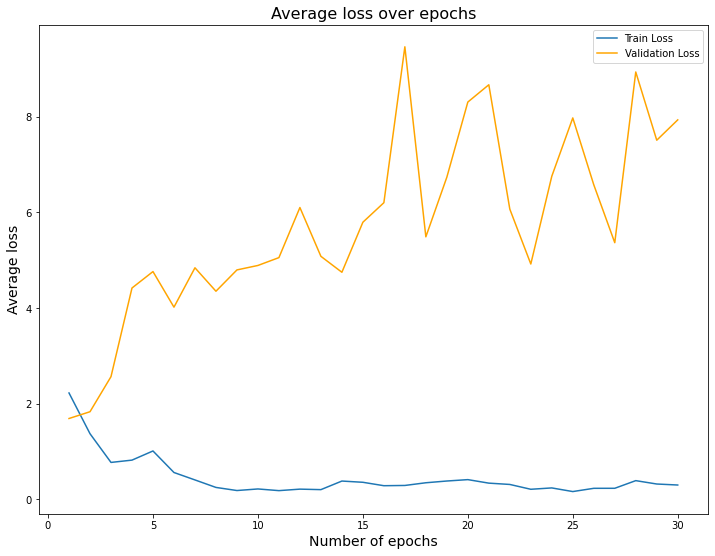

In [71]:
def plot_loss(train_losses, val_losses):
    """
    You may end up plotting the training loss and validation loss multiple times
    It is better to implement a plot function instead of rewriting the plotting steps
    """
    plt.figure(figsize = (12,9))
    plt.plot(range(1,len(train_losses)+1), train_losses)
    plt.plot(range(1,len(val_losses)+1), val_losses, color='orange')
    plt.legend(['Train Loss','Validation Loss'], loc='upper right')
    plt.xlabel('Number of epochs',fontsize=14)
    plt.ylabel('Average loss',fontsize=14)
    plt.title("Average loss over epochs",fontsize=16)
    plt.show()
plot_loss(train_losses, val_losses)

In [72]:
from sklearn.metrics import classification_report

print(classification_report(data_test['class'], val_preds))

              precision    recall  f1-score   support

           0       0.53      0.38      0.44        50
           1       0.42      0.38      0.40        50
           2       0.27      0.68      0.39        50
           3       0.35      0.16      0.22        50
           4       0.56      0.10      0.17        50
           5       0.30      0.38      0.34        50

    accuracy                           0.35       300
   macro avg       0.40      0.35      0.33       300
weighted avg       0.40      0.35      0.33       300

